<a href="https://colab.research.google.com/github/gopaldewoolkar/Langgraph/blob/main/LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chatbot with LangGraph

In [1]:
! pip install langgraph langsmith langchain langchain_groq langchain_community langchain_core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: langchain_core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [2]:
from google.colab import userdata
groq_api_key = userdata.get("groq_api_key")
langsmith = userdata.get("langsmith_api_key")


In [3]:
import os
os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph"


In [4]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key = groq_api_key, model_name = "Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7848928c2f80>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7848928c3dc0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Start building ChatBot using LangGraph

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [3]:
graph_builder = StateGraph(State)
graph_builder

In [4]:
def chatbot(state:State):
  return {"messages": llm.invoke(state["messages"])}

In [5]:
graph_builder.add_node("chatbot", chatbot)

In [6]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [7]:
graph = graph_builder.compile()

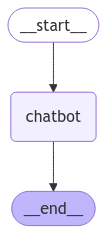

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [14]:
while True:
  user_input = input("User: ")
  if user_input.lower() in ["exit", "quit", "q"]:
    print("Good Bye...")
    break
  for event in graph.stream({'messages': ("user", user_input)}):
    print(event.values())
    for value in event.values():
      print(value['messages'])
      print("Assistant: ", value['messages'].content)

User: Hello
dict_values([{'messages': AIMessage(content='Hello! 👋\n\nHow can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 10, 'total_tokens': 25, 'completion_time': 0.027272727, 'prompt_time': 6.1e-07, 'queue_time': 0.003554601, 'total_time': 0.027273337}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-6cececab-a5e0-40c6-b79a-5c16c4923609-0', usage_metadata={'input_tokens': 10, 'output_tokens': 15, 'total_tokens': 25})}])
content='Hello! 👋\n\nHow can I help you today? 😊\n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 10, 'total_tokens': 25, 'completion_time': 0.027272727, 'prompt_time': 6.1e-07, 'queue_time': 0.003554601, 'total_time': 0.027273337}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-6cececab-a5e0-40c

## LangGraph ChatBot with Tools

In [1]:
! pip install langgraph langsmith langchain langchain_groq langchain_community langchain_core

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

In [3]:
!pip install arxiv wikipedia

In [4]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

#  Arxiv and Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=300)
wiki_tool = WikipediaAPIWrapper(api_wrapper=api_wrapper)


In [5]:
wiki_tool.run("Who is sir Ratan Tata?")

"Page: Ratan Tata\nSummary: Ratan Naval Tata (28 December 1937 – 9 October 2024) was an  Indian industrialist and philanthropist. He served as the chairman of Tata Group and Tata Sons from 1991 to 2012 and he held the position of interim chairman from October 2016 to February 2017. In 2000, he received the Padma Bhushan, the third highest civilian honour in India, followed by the Padma Vibhushan, the country's second highest civilian honour, in 2008.\nRatan Tata was the son of Naval Tata, who was adopted by Ratanji Tata, son of Jamshedji Tata, the founder of the Tata Group. He graduated from Cornell University College of Architecture with a bachelor's degree in architecture. He had also attended the Harvard Business School (HBS) Advanced Management program in 1975. He joined the Tata Group in 1962, starting on the shop floor of Tata Steel. He later succeeded J. R. D. Tata as chairman of Tata Sons upon the latter's retirement in 1991. During his tenure, the Tata Group acquired Tetley, J

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [17]:
# here you can add any no. of tools just by giving comma, but now we are just trying with one tool
tools = [arxiv_tool]

In [9]:
# LangGraph Application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [10]:
from langgraph.graph import StateGraph, START, END

In [11]:
graph_builder = StateGraph(State)

In [12]:
from langchain_groq import ChatGroq

In [13]:
from google.colab import userdata
groq_api_key = userdata.get("groq_api_key")

In [14]:
llm = ChatGroq(groq_api_key= groq_api_key, model_name= "Gemma2-9b-It")

In [15]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d394c7d87c0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d394c7d9390>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [18]:
llm_with_tools=llm.bind_tools(tools=tools)

In [19]:
def chatbot(state:State):
  return {'messages':[llm_with_tools.invoke(state['messages'])]}

In [20]:
from langgraph.prebuilt import ToolNode, tools_condition

In [21]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node= ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [23]:
graph = graph_builder.compile()

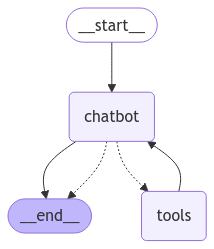

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [25]:
user_input = "Hi there, What are important things from 'Attention all you need'"

events= graph.stream(
    {"messages": [("user", user_input)]}, stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there, What are important things from 'Attention all you need'
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_11mk)
 Call ID: call_11mk
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with 
================================== Ai Message ==================================

This paper explores the efficiency of large language models (LLMs) and suggests that not all attention heads are necessary for inference.
